#  **Data Science Assignment - Web3 Trading Team**
Created by - Uday Bolla

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

if not os.path.exists('csv_files'):
    os.makedirs('csv_files')
    print("Created 'csv_files' directory.")

if not os.path.exists('outputs'):
    os.makedirs('outputs')
    print("Created 'outputs' directory. All plots will be saved here.")

**Loading and Inspecting Data**

In [5]:

try:
    trader_df = pd.read_csv("csv_files/historical_data.csv")
    sentiment_df = pd.read_csv("csv_files/fear_greed_index.csv")
    print("Data loaded successfully.")
    print(f"Trader data shape: {trader_df.shape}")
    print(f"Sentiment data shape: {sentiment_df.shape}")
except FileNotFoundError:
    print("Error: Files not found. Make sure 'historical_data.csv' and 'fear_greed_index.csv' are in the 'csv_files' directory.")

# Display first few rows
print("\n--- Trader Data Head ---")
print(trader_df.head())

print("\n--- Trader Data Info ---")
trader_df.info()

print("\n--- Sentiment Data Head ---")
print(sentiment_df.head())

print("\n--- Sentiment Data Info ---")
sentiment_df.info()

Data loaded successfully.
Trader data shape: (211224, 16)
Sentiment data shape: (2644, 4)

--- Trader Data Head ---
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521   

**Data Cleaning and Merging**

In [7]:
print("\nStarting data cleaning and preparation...")

# Converting 'Timestamp IST' to a standard format for merging
trader_df['datetime'] = pd.to_datetime(trader_df['Timestamp IST'], format='%d-%m-%Y %H:%M')
trader_df['date'] = trader_df['datetime'].dt.strftime('%Y-%m-%d')

# Converting key columns to numeric types
trader_df['Closed PnL'] = pd.to_numeric(trader_df['Closed PnL'], errors='coerce')
trader_df['Size USD'] = pd.to_numeric(trader_df['Size USD'], errors='coerce')

# Drop missing data rows
trader_df.dropna(subset=['Closed PnL', 'Size USD', 'date'], inplace=True)
print("Trader data cleaned.")

# Ensure the 'date' column is in the same format
sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.strftime('%Y-%m-%d')
print("Sentiment data cleaned.")

# Merging Datasets
print("Merging datasets on 'date'...")
merged_df = pd.merge(trader_df, sentiment_df, on='date', how='left')

# Drop trades where there was no matching sentiment data
merged_df.dropna(subset=['classification'], inplace=True)
print(f"Merged data shape: {merged_df.shape}")

# Group 'Extreme' categories
def simplify_sentiment(classification):
    if classification in ['Extreme Fear', 'Fear']:
        return 'Fear'
    elif classification in ['Extreme Greed', 'Greed']:
        return 'Greed'
    else:
        return 'Neutral'

merged_df['sentiment'] = merged_df['classification'].apply(simplify_sentiment)

print("\nSentiment categories simplified:")
print(merged_df['sentiment'].value_counts())

print("\n--- Final Merged Data Head ---")
print(merged_df[['date', 'Account', 'Side', 'Size USD', 'Closed PnL', 'sentiment']].head())


Starting data cleaning and preparation...
Trader data cleaned.
Sentiment data cleaned.
Merging datasets on 'date'...
Merged data shape: (211218, 21)

Sentiment categories simplified:
sentiment
Greed      90295
Fear       83237
Neutral    37686
Name: count, dtype: int64

--- Final Merged Data Head ---
         date                                     Account Side  Size USD  \
0  2024-12-02  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  BUY   7872.16   
1  2024-12-02  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  BUY    127.68   
2  2024-12-02  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  BUY   1150.63   
3  2024-12-02  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  BUY   1142.04   
4  2024-12-02  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  BUY     69.75   

   Closed PnL sentiment  
0         0.0     Greed  
1         0.0     Greed  
2         0.0     Greed  
3         0.0     Greed  
4         0.0     Greed  


**Plot 1.1: Average Profitability vs Sentiment**

Analyzing: Profitability vs. Sentiment
Saved: outputs/1_avg_pnl_by_sentiment.png


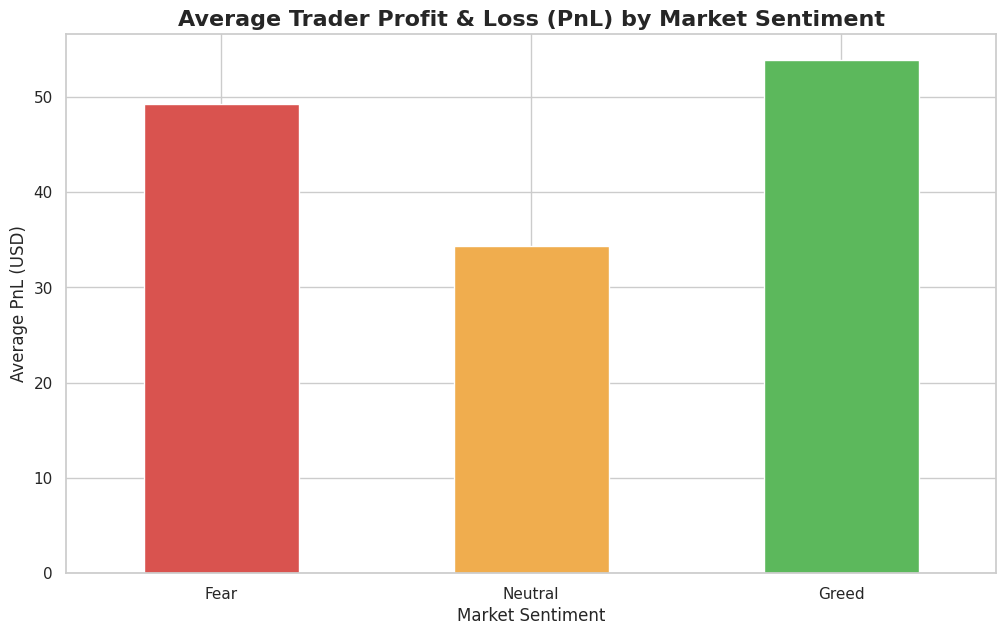

In [8]:
print("Analyzing: Profitability vs. Sentiment")
sentiment_order = ['Fear', 'Neutral', 'Greed']

sns.set(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['figure.dpi'] = 100

# Calculate average PnL
avg_pnl_by_sentiment = merged_df.groupby('sentiment')['Closed PnL'].mean().reindex(sentiment_order)

plt.figure()
avg_pnl_by_sentiment.plot(kind='bar', color=['#d9534f', '#f0ad4e', '#5cb85c'])
plt.title('Average Trader Profit & Loss (PnL) by Market Sentiment', fontsize=16, fontweight='bold')
plt.ylabel('Average PnL (USD)')
plt.xlabel('Market Sentiment')
plt.xticks(rotation=0)
plt.savefig('outputs/1_avg_pnl_by_sentiment.png')
print("Saved: outputs/1_avg_pnl_by_sentiment.png")
plt.show()

**Plot 1.2: Total Trading Volume vs Sentiment**

Analyzing: Trading Volume vs. Sentiment
Saved: outputs/2_total_volume_by_sentiment.png


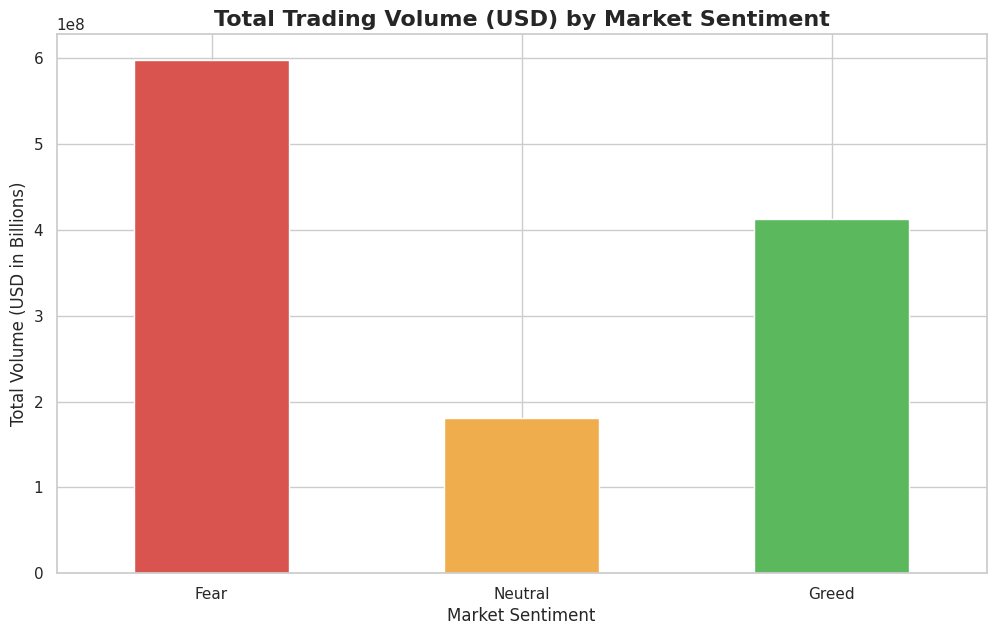

In [9]:
print("Analyzing: Trading Volume vs. Sentiment")
sentiment_order = ['Fear', 'Neutral', 'Greed']

# Calculate total volume
total_volume_by_sentiment = merged_df.groupby('sentiment')['Size USD'].sum().reindex(sentiment_order)

plt.figure()
total_volume_by_sentiment.plot(kind='bar', color=['#d9534f', '#f0ad4e', '#5cb85c'])
plt.title('Total Trading Volume (USD) by Market Sentiment', fontsize=16, fontweight='bold')
plt.ylabel('Total Volume (USD in Billions)')
plt.xlabel('Market Sentiment')
plt.xticks(rotation=0)
plt.savefig('outputs/2_total_volume_by_sentiment.png')
print("Saved: outputs/2_total_volume_by_sentiment.png")
plt.show()

**Plot 1.3: Trader Behavior (BUY vs. SELL Ratio) vs Sentiment**

Analyzing: BUY/SELL Ratio vs. Sentiment
Saved: outputs/3_behavior_vs_sentiment.png


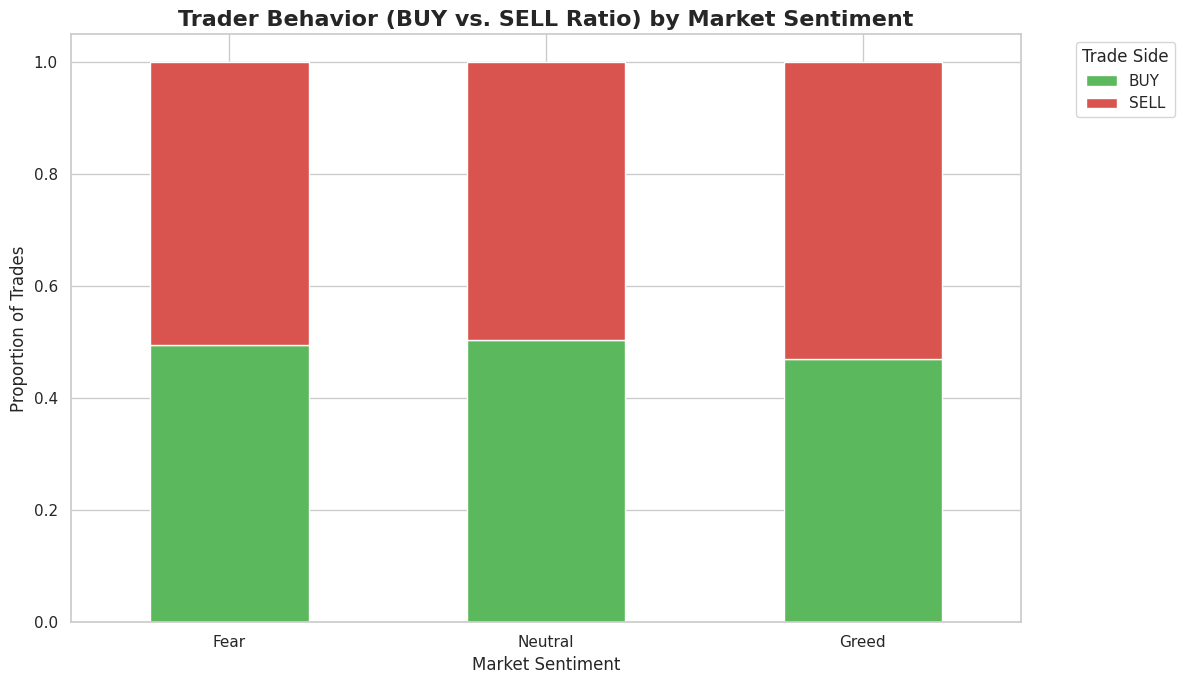

In [10]:
print("Analyzing: BUY/SELL Ratio vs. Sentiment")
sentiment_order = ['Fear', 'Neutral', 'Greed']

# count of BUY vs. SELL actions per sentiment
behavior_crosstab = pd.crosstab(merged_df['sentiment'], merged_df['Side'], normalize='index').reindex(sentiment_order)
behavior_crosstab = behavior_crosstab[['BUY', 'SELL']] # Focus only on BUY/SELL

behavior_crosstab.plot(kind='bar', stacked=True, color=['#5cb85c', '#d9534f'], figsize=(12, 7))
plt.title('Trader Behavior (BUY vs. SELL Ratio) by Market Sentiment', fontsize=16, fontweight='bold')
plt.ylabel('Proportion of Trades')
plt.xlabel('Market Sentiment')
plt.legend(title='Trade Side', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('outputs/3_behavior_vs_sentiment.png')
print("Saved: outputs/3_behavior_vs_sentiment.png")
plt.show()

**Plot 2.1 - Top 10% and Bottom 10% traders analysis**


Starting 'Stand Out' Cohort Analysis...
Identified 4 top traders and 4 bottom traders.
Cohort DataFrames created.
Analyzing: Cohort Behavior (BUY/SELL) during FEAR
Saved: outputs/4_cohort_analysis_fear.png


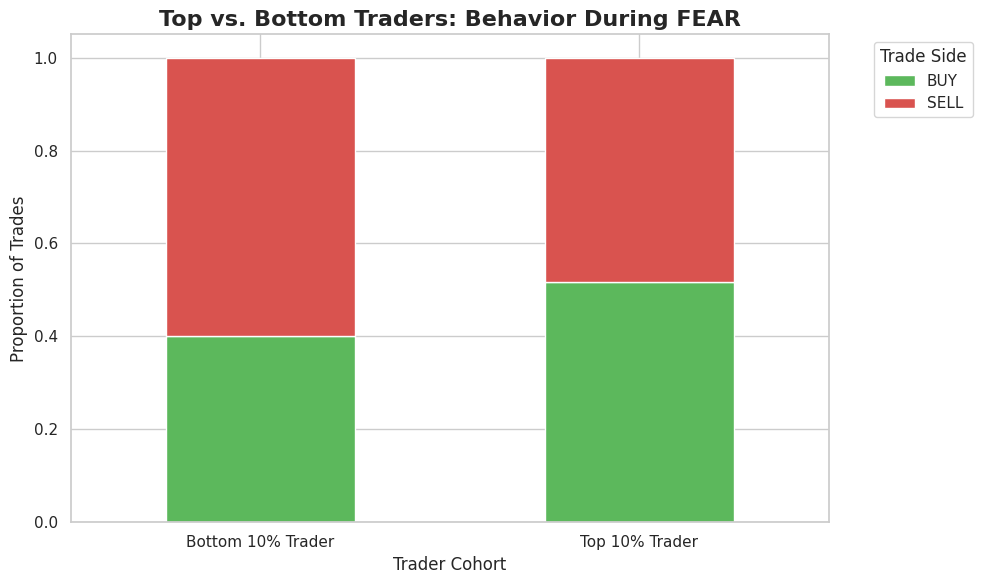

In [11]:


# Identify Top/Bottom Traders
# Calculate total PnL for each account
trader_performance = merged_df.groupby('Account')['Closed PnL'].sum().sort_values()

# Get the top 10% and bottom 10%
top_10_percentile = trader_performance.quantile(0.90)
bottom_10_percentile = trader_performance.quantile(0.10)

top_traders = trader_performance[trader_performance >= top_10_percentile].index
bottom_traders = trader_performance[trader_performance <= bottom_10_percentile].index

print(f"Identified {len(top_traders)} top traders and {len(bottom_traders)} bottom traders.")

top_trader_df = merged_df[merged_df['Account'].isin(top_traders)].copy()
bottom_trader_df = merged_df[merged_df['Account'].isin(bottom_traders)].copy()


top_trader_df['Cohort'] = 'Top 10% Trader'
bottom_trader_df['Cohort'] = 'Bottom 10% Trader'
cohort_df = pd.concat([top_trader_df, bottom_trader_df])

print("Cohort DataFrames created.")

print("Analyzing: Cohort Behavior (BUY/SELL) during FEAR")
fear_behavior = cohort_df[cohort_df['sentiment'] == 'Fear']
cohort_behavior_crosstab = pd.crosstab(fear_behavior['Cohort'], fear_behavior['Side'], normalize='index')
cohort_behavior_crosstab = cohort_behavior_crosstab[['BUY', 'SELL']]


cohort_behavior_crosstab.plot(kind='bar', stacked=True, color=['#5cb85c', '#d9534f'], figsize=(10, 6))
plt.title('Top vs. Bottom Traders: Behavior During FEAR', fontsize=16, fontweight='bold')
plt.ylabel('Proportion of Trades')
plt.xlabel('Trader Cohort')
plt.xticks(rotation=0)
plt.legend(title='Trade Side', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('outputs/4_cohort_analysis_fear.png')
print("Saved: outputs/4_cohort_analysis_fear.png")
plt.show()

**Plot 3.1: Risk Management (Average Trade Size)**


Analyzing: EXTRA INSIGHT 1: Risk Management
Saved: outputs/5_risk_vs_sentiment.png


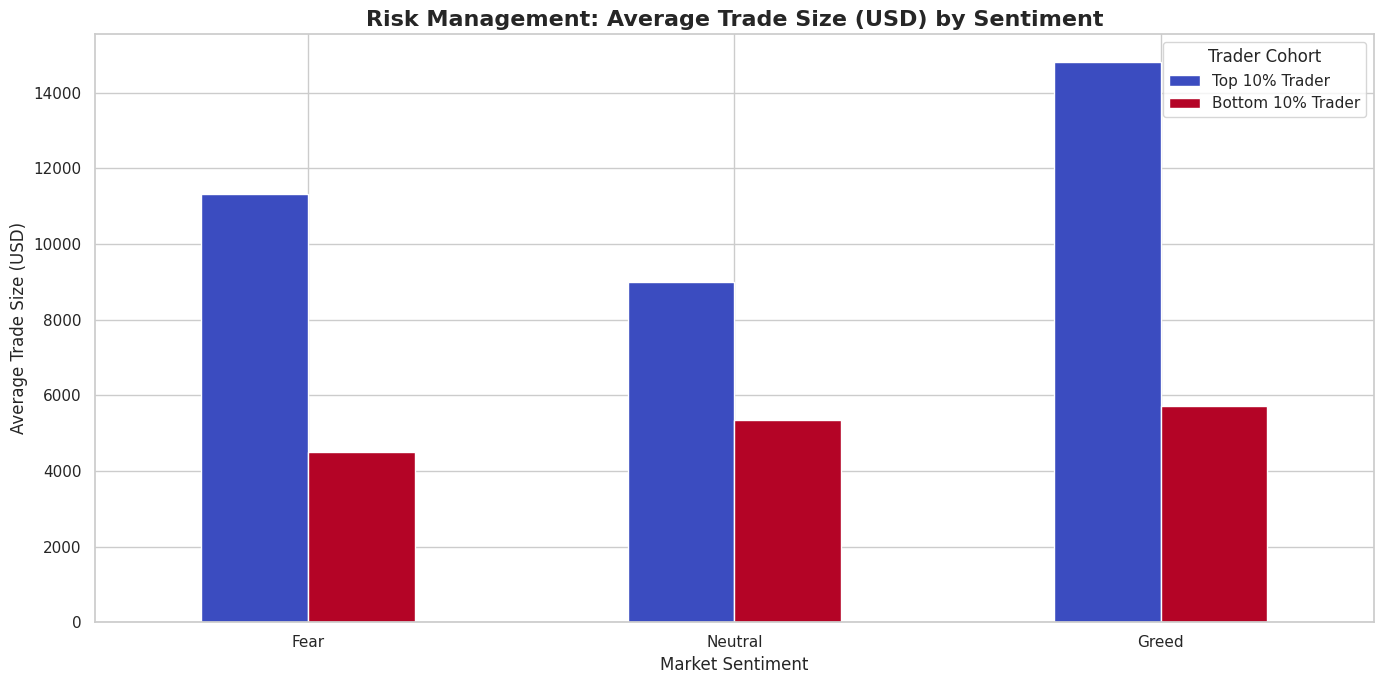

In [12]:

sentiment_order = ['Fear', 'Neutral', 'Greed']

# Calculating average trade size by sentiment
avg_trade_size = cohort_df.groupby(['sentiment', 'Cohort'])['Size USD'].mean().unstack()

avg_trade_size = avg_trade_size.reindex(sentiment_order)
avg_trade_size = avg_trade_size[['Top 10% Trader', 'Bottom 10% Trader']]


avg_trade_size.plot(kind='bar', figsize=(14, 7), colormap='coolwarm')
plt.title('Risk Management: Average Trade Size (USD) by Sentiment', fontsize=16, fontweight='bold')
plt.ylabel('Average Trade Size (USD)')
plt.xlabel('Market Sentiment')
plt.xticks(rotation=0)
plt.legend(title='Trader Cohort')
plt.tight_layout()
plt.savefig('outputs/5_risk_vs_sentiment.png')
print("Saved: outputs/5_risk_vs_sentiment.png")
plt.show()

**Plot 3.2: Asset Selection during FEAR**

Saved: outputs/6_asset_selection.png


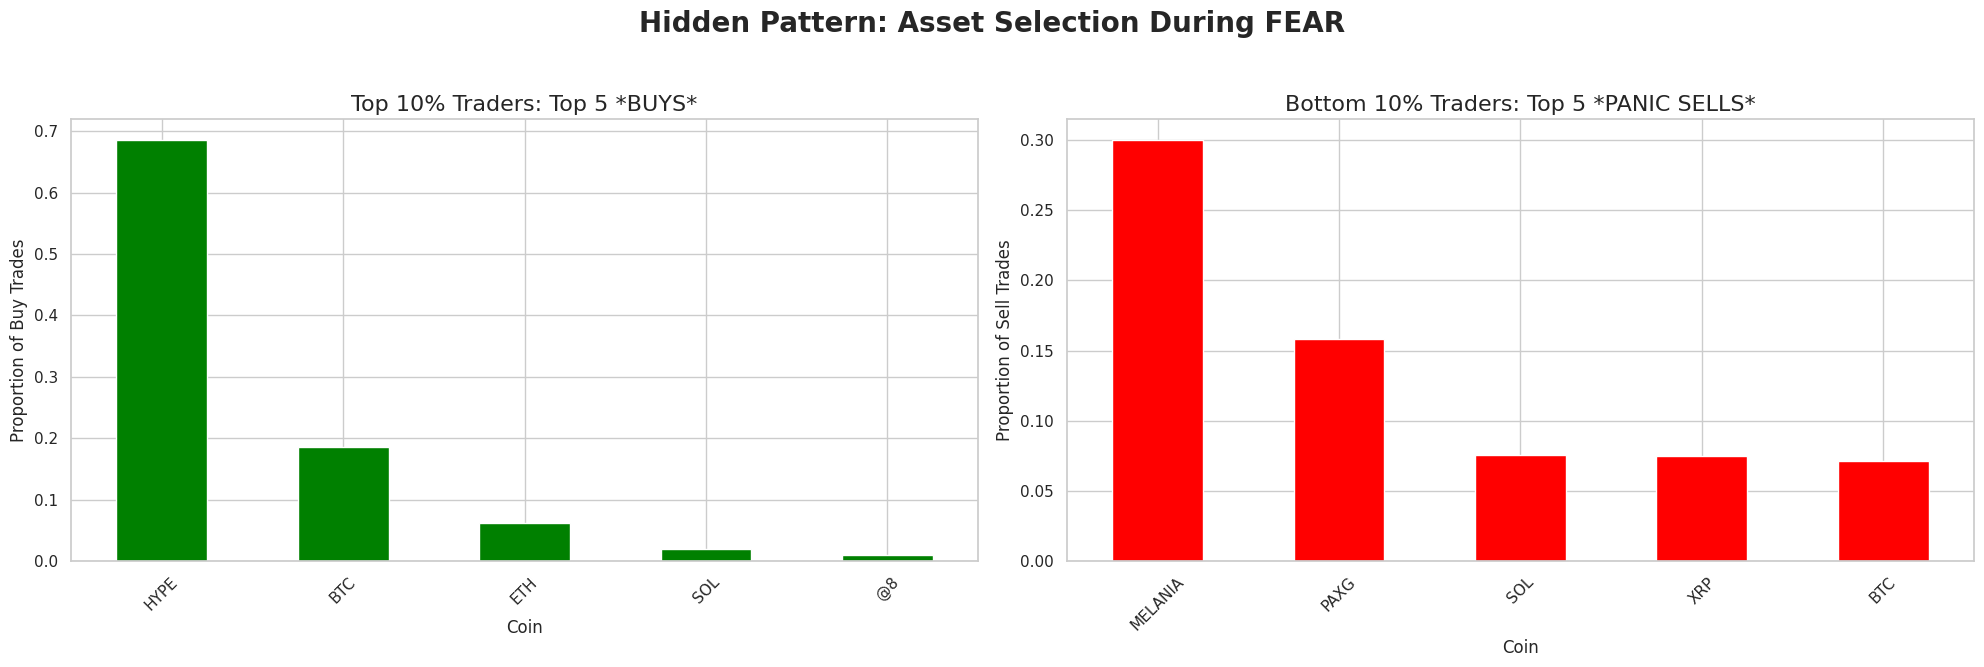

In [13]:


# Top Trader Fear Buys
top_trader_fear_buys = top_trader_df[
    (top_trader_df['sentiment'] == 'Fear') & (top_trader_df['Side'] == 'BUY')
]
top_fear_buy_assets = top_trader_fear_buys['Coin'].value_counts(normalize=True).head(5)

# Bottom Trader Fear Sells
bottom_trader_fear_sells = bottom_trader_df[
    (bottom_trader_df['sentiment'] == 'Fear') & (bottom_trader_df['Side'] == 'SELL')
]
bottom_fear_sell_assets = bottom_trader_fear_sells['Coin'].value_counts(normalize=True).head(5)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle('Hidden Pattern: Asset Selection During FEAR', fontsize=20, fontweight='bold')


top_fear_buy_assets.plot(kind='bar', ax=ax1, color='green')
ax1.set_title('Top 10% Traders: Top 5 *BUYS*', fontsize=16)
ax1.set_ylabel('Proportion of Buy Trades')
ax1.tick_params(axis='x', rotation=45)


bottom_fear_sell_assets.plot(kind='bar', ax=ax2, color='red')
ax2.set_title('Bottom 10% Traders: Top 5 *PANIC SELLS*', fontsize=16)
ax2.set_ylabel('Proportion of Sell Trades')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('outputs/6_asset_selection.png')
print("Saved: outputs/6_asset_selection.png")
plt.show()

**Plot 3.3: Trader Consistency (Win Rate)**

Saved: outputs/7_win_rate_vs_sentiment.png


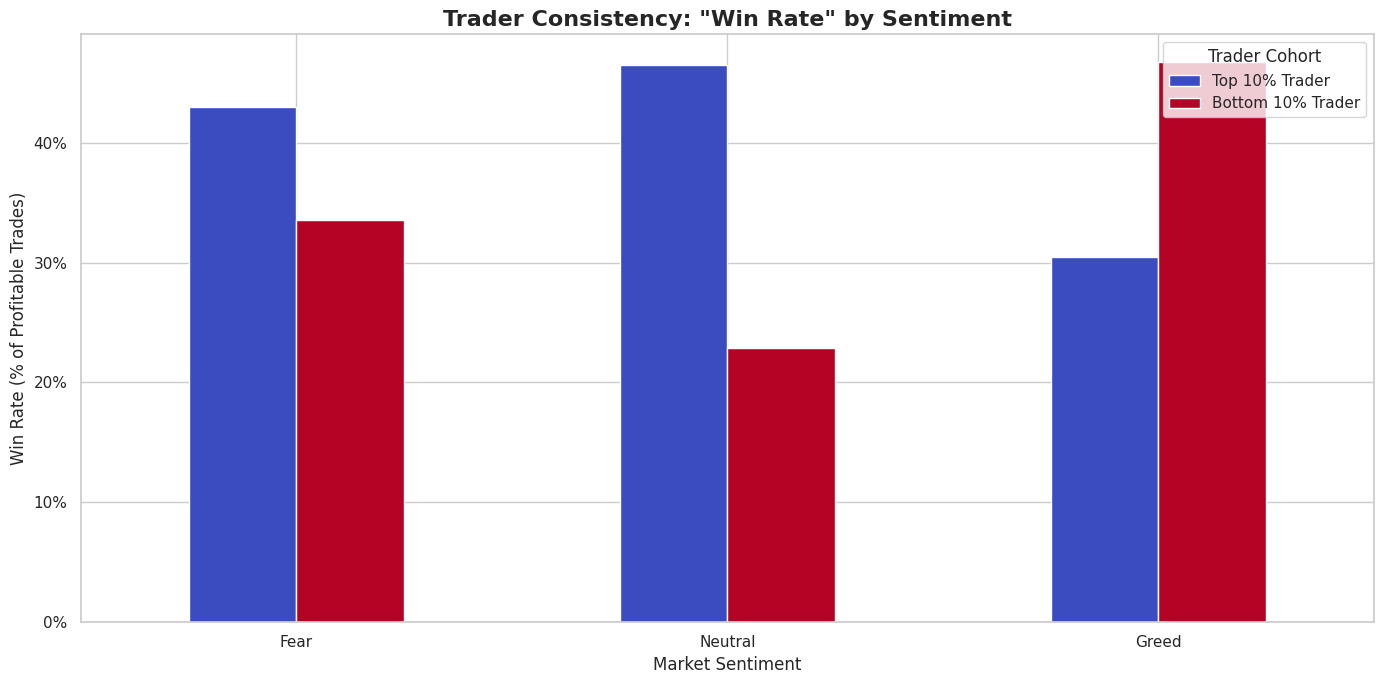

In [14]:

sentiment_order = ['Fear', 'Neutral', 'Greed']

# Calculating Win Rate
cohort_df['is_profitable'] = cohort_df['Closed PnL'] > 0
win_rate = cohort_df.groupby(['sentiment', 'Cohort'])['is_profitable'].mean().unstack()

win_rate = win_rate.reindex(sentiment_order)
win_rate = win_rate[['Top 10% Trader', 'Bottom 10% Trader']]

win_rate.plot(kind='bar', figsize=(14, 7), colormap='coolwarm')
plt.title('Trader Consistency: "Win Rate" by Sentiment', fontsize=16, fontweight='bold')
plt.ylabel('Win Rate (% of Profitable Trades)')
plt.xlabel('Market Sentiment')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}')) # Format Y-axis as percentage
plt.xticks(rotation=0)
plt.legend(title='Trader Cohort')
plt.tight_layout()
plt.savefig('outputs/7_win_rate_vs_sentiment.png')
print("Saved: outputs/7_win_rate_vs_sentiment.png")
plt.show()
